In [1]:
import argparse
import tensorflow as tf
import numpy as np
from utils.coco_dataset_manager import *
import os
from tqdm.auto import tqdm
import xml.etree.ElementTree as ET
import tensorflow as tf
from tensorflow import keras
import keras_cv
from utils.yolo_utils import *
from utils.custom_retinanet import prepare_image
from utils.nonmaxsuppression import PreBayesianNMS
import os
import cv2

2023-11-14 18:04:08.175783: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-14 18:04:08.223617: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Using TensorFlow backend


In [2]:
def dict_to_tuple(inputs):
    return inputs["images"], inputs["bounding_boxes"]

output_folder = "image_test_results"  # Change this to the desired output folder

# Create the output folder if it doesn't exist
os.makedirs(output_folder, exist_ok=True)

# Hardcoded values
json_path = "/remote_home/Thesis/annotations/instances_train2017.json"
save_path = "/remote_home/Thesis/train"
download = "False"
batch_size = 16
epochs = 500
num_imgs = 10
checkpoint_path = "yolo"
max_iou = 0.2
min_confidence = 0.018
cls_path = "/remote_home/Thesis/Prebayesian/yolo-cls-list.txt"

# Load the class lists from text, if not specified, it gets all 80 classes
if cls_path == "":
    cls_list = None
else:
    with open(cls_path) as f:
        cls_list = f.readlines()
        cls_list = [cls.replace("\n", "") for cls in cls_list]

# The detector will only be the length of the class list
num_classes = 80 if cls_list is None else len(cls_list)
coco_ds = CocoDSManager(json_path, save_path, max_samples=num_imgs, download=download == "True", yxyw_percent=False, cls_list=cls_list)

train_ds = coco_ds.train_ds
val_ds = coco_ds.val_ds

print("TRAIN DATA LENGTH")
print(len(list(train_ds)))

augmenter = keras.Sequential(
    layers=[
        keras_cv.layers.RandomFlip(mode="horizontal", bounding_box_format="xywh"),
        keras_cv.layers.RandomShear(
            x_factor=0.2, y_factor=0.2, bounding_box_format="xywh"
        ),
        keras_cv.layers.JitteredResize(
            target_size=(640, 640), scale_factor=(0.75, 1.3), bounding_box_format="xywh"
        ),
    ]
)

train_ds = train_ds.shuffle(batch_size * 4)
train_ds = train_ds.ragged_batch(batch_size, drop_remainder=True)
train_ds = train_ds.map(augmenter, num_parallel_calls=tf.data.AUTOTUNE)

resizing = keras_cv.layers.JitteredResize(
    target_size=(640, 640),
    scale_factor=(0.75, 1.3),
    bounding_box_format="xywh",
)

val_ds = val_ds.shuffle(batch_size * 4)
val_ds = val_ds.ragged_batch(batch_size, drop_remainder=True)
val_ds = val_ds.map(resizing, num_parallel_calls=tf.data.AUTOTUNE)

train_ds = train_ds.map(dict_to_tuple, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)

val_ds = val_ds.map(dict_to_tuple, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)

backbone = keras_cv.models.YOLOV8Backbone.from_preset(
    "yolo_v8_s_backbone_coco"  # We will use yolov8 small backbone with coco weights
)

nms = PreBayesianNMS("xywh", True, confidence_threshold=min_confidence)

model = keras_cv.models.YOLOV8Detector(
    num_classes=num_classes,
    bounding_box_format="xywh",
    backbone=backbone,
    fpn_depth=2,
    prediction_decoder=nms
)

LEARNING_RATE = 0.00025
GLOBAL_CLIPNORM = 10

optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE, global_clipnorm=GLOBAL_CLIPNORM)
model.compile(optimizer=optimizer, classification_loss="binary_crossentropy", box_loss="ciou", jit_compile=False)

latest_checkpoint = tf.train.latest_checkpoint("/remote_home/Thesis/Prebayesian/best_weights")
model.load_weights(latest_checkpoint).expect_partial()



loading annotations into memory...
Done (t=13.90s)
creating index...
index created!


2023-11-14 18:06:44.764863: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 30955 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:1a:00.0, compute capability: 7.0
2023-11-14 18:06:44.765766: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 30955 MB memory:  -> device: 1, name: Tesla V100-SXM2-32GB, pci bus id: 0000:1b:00.0, compute capability: 7.0
2023-11-14 18:06:44.766489: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 30955 MB memory:  -> device: 2, name: Tesla V100-SXM2-32GB, pci bus id: 0000:3d:00.0, compute capability: 7.0
2023-11-14 18:06:44.767223: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:3 with 30955 MB memory:  -> device: 3, name: Tesla V100-SXM2-32GB, pci bus id

TRAIN DATA LENGTH
8


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: annotated name 'cls_predictions' can't be nonlocal (__autograph_generated_fileux_m9i25.py, line 58)
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: annotated name 'cls_predictions' can't be nonlocal (__autograph_generated_fileux_m9i25.py, line 58)
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
THRESHOLD 0.018
Instructions for updating:
Use fn_output_signature instead


2023-11-14 18:07:44.514681: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8906
2023-11-14 18:07:46.902497: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


1/1 [==============================] - 8s 8s/step
Ground Truth


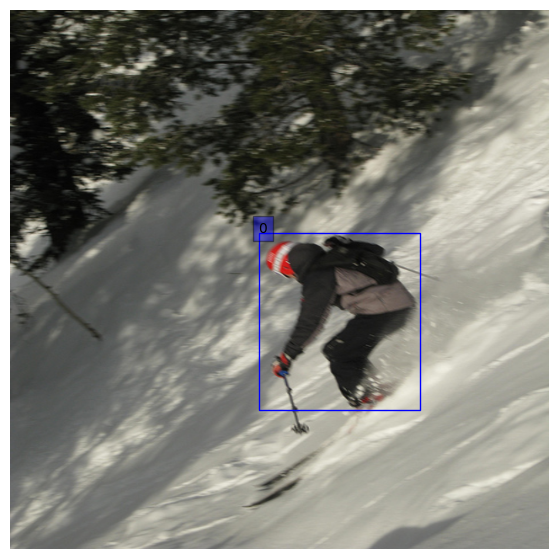

Predctions


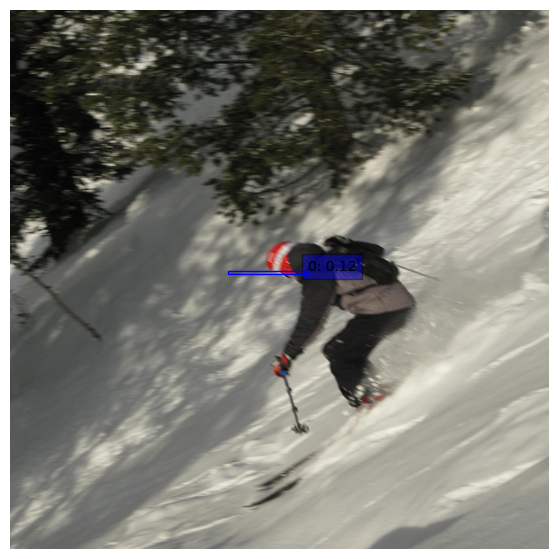

1/1 [==============================] - 0s 47ms/step
Ground Truth


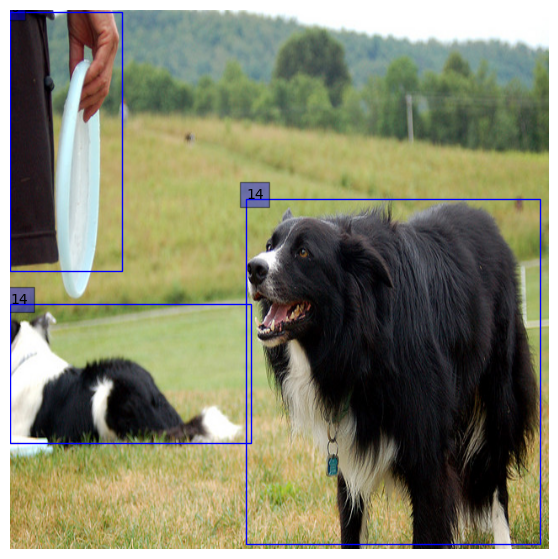

Predctions


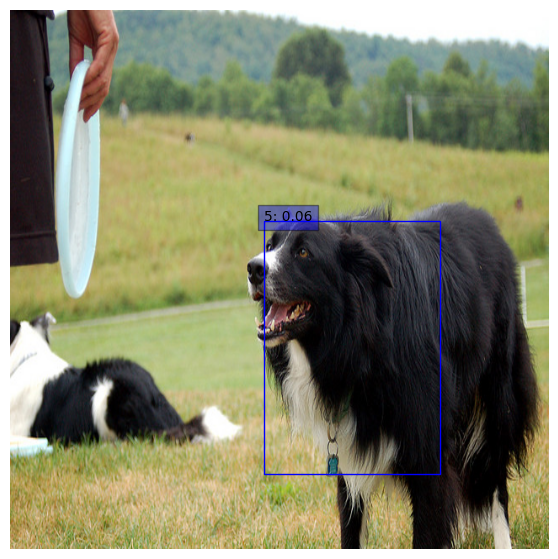

1/1 [==============================] - 0s 49ms/step
Ground Truth


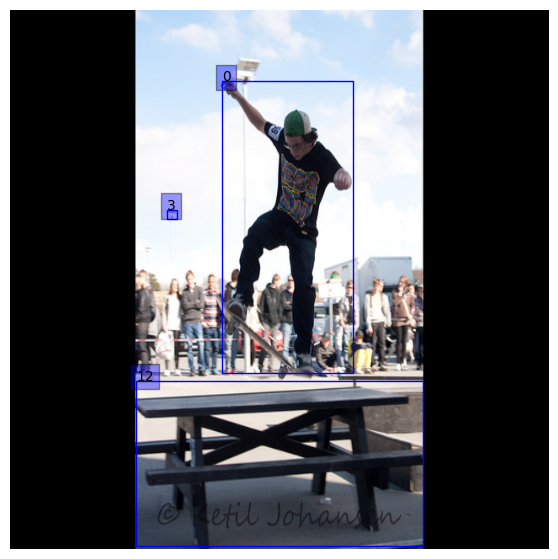

Predctions


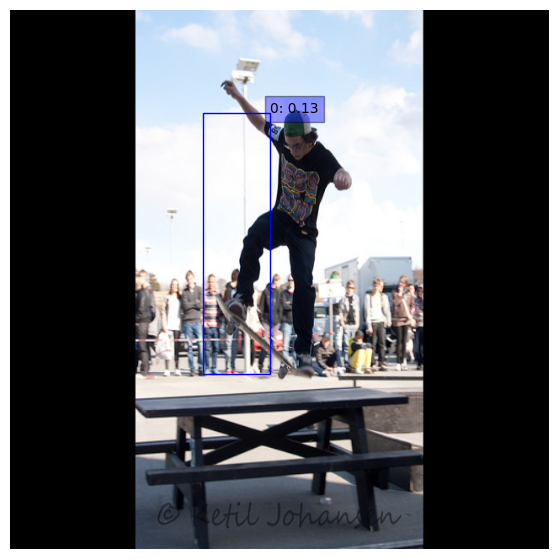

1/1 [==============================] - 0s 47ms/step
Ground Truth


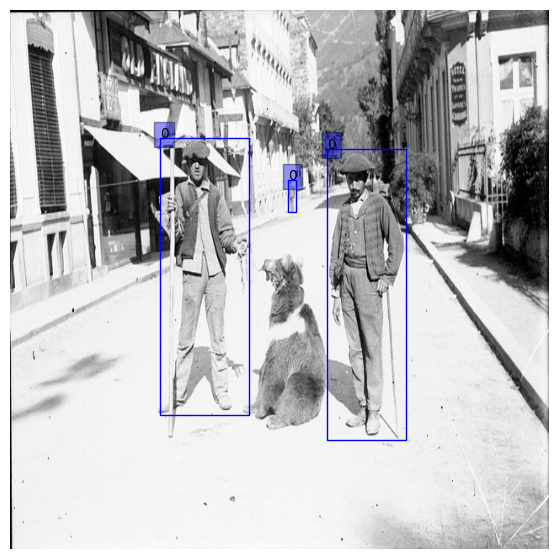

Predctions


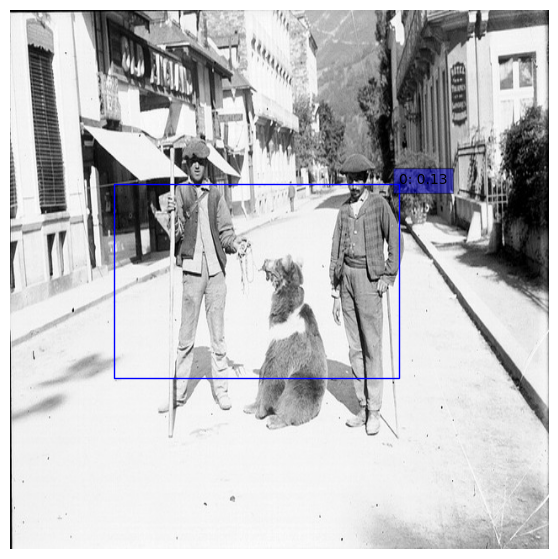

1/1 [==============================] - 0s 47ms/step
Ground Truth


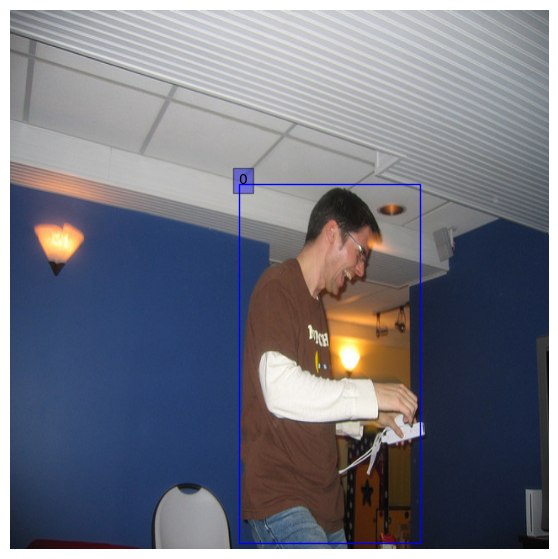

Predctions


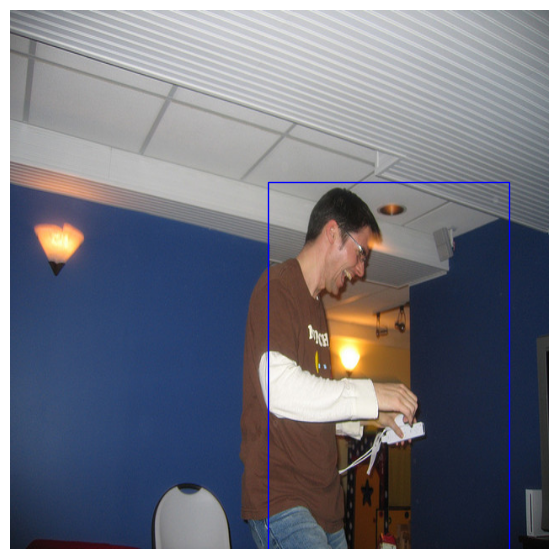

In [3]:
for sample in coco_ds.train_ds.take(5):

    try:
        image = tf.cast(sample["images"], dtype=tf.float32)

    
        input_image, ratio = prepare_image(image)
        detections = model.predict(input_image)

        boxes = np.asarray(detections["boxes"][0])

        cls_prob = np.asarray(detections["cls_prob"][0])

        # print(np.max(cls_prob[0]))
        # print(np.sum(cls_prob[0]))

        cls_id = np.asarray(detections["cls_idx"][0])

        key_list = coco_ds.key_list
        
        # print(boxes)
        # print(cls_id)

        # print(cls_prob[0])

        correct_prob = []
        for i in range(len(cls_prob)):
            correct_prob.append(cls_prob[i][cls_id[i]])

        

        gt_name = [coco_ds.coco.cats[key_list[int(x)]]['name'] for x in np.asarray(sample["bounding_boxes"]["classes"])]
                
        cls_name = [coco_ds.coco.cats[key_list[int(x)]]['name'] for x in np.asarray(cls_id)]

        print("Ground Truth")
        visualize_dataset(image, sample["bounding_boxes"]["boxes"][:3], sample["bounding_boxes"]["classes"][:3])

        print("Predctions")
        visualize_detections(image, [boxes[0]], [cls_id[0].item()] if cls_id[0].size == 1 else list(cls_id[0]), [cls_prob[0].item()] if cls_prob[0].size == 1 else list(cls_prob[0]))

        # print(sample["bounding_boxes"]["boxes"])

        # print("VS")
        # print(boxes)


        # visualize_detections_and_gt(image, boxes, cls_name, correct_prob, sample["bounding_boxes"]["boxes"], gt_name)
    except IndexError:
        print("NO VALID DETECTIONS")
        continue
    # show_frame_no_deep(np.asarray(image), np.asarray(detections["boxes"][0]), 2000)
